Задача

Запустите A/A-тест

Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.

Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)

Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста


Загружаем данные и проводим А/А-тест:

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';')

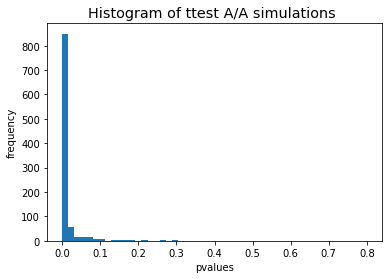

0.924

In [3]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant==1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant==0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

По результатам теста FPR > альфа, распределение сильно скошено влево.

Взглянем на показатель конверсии относительно версии устройства:

In [4]:
df.groupby(['experimentVariant', 'version'], as_index=False)\
    .agg({'purchase': 'mean'})\
    .sort_values('purchase')

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
4,1,v2.8.0,0.045606
3,0,v3.8.0.0,0.057604
2,0,v3.7.4.0,0.059943
7,1,v3.8.0.0,0.062848
6,1,v3.7.4.0,0.063018
5,1,v2.9.0,0.071304
1,0,v2.9.0,0.074658


Как видно из результирующей таблицы, конверсия в тестовой группе '0' и версии устройства 'v2.8.0' во много раз отличается от аналогичного показателя для тестовой группы '1'.

Исключим из наших данных всех пользователей с устройством version == 'v2.8.0' и повторим эксперимент:

In [5]:
df1 = df.query('version != "v2.8.0"')

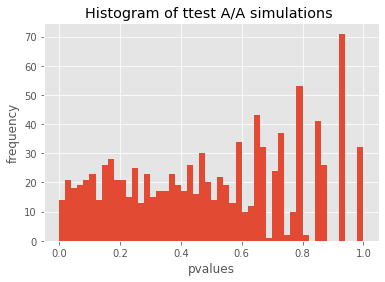

0.045

In [6]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df1[df1.experimentVariant==1]['purchase'].sample(n_s, replace = False).values
    s2 = df1[df1.experimentVariant==0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Как видно из повторного эксперимента, FPR < альфа.

На основе анализа двух проведенных эксперементов можно сделать вывод, что поломка сплит-системы произошла на версии приложения v2.8.0.

# ответ преподавателя: вы верно решили задание!

Логика решения задачи была верной: вы последовательно сравнивали градации в измерениях по целевой переменной. 


В качестве бонуса, ниже показано альтернативное решение задачи

In [6]:

from statsmodels.stats.proportion import proportions_ztest
df = pd.read_csv('hw_aa.csv', sep=';',index_col=0, decimal=',')
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [9]:

# основная функция для расчета АА с синтетическими тестами
def metric_fpr(df_x, df_y, metric_col, n_sim, n_s_perc, n_s_min, estimator, *args, **kwargs):
    stat_res = {
        'aa' : {
            'pvalue': [], 
            'mu_x': [], 
            'mu_y': []
        },
        'fpr': {
            'fpr_95': 0
        }
    }
    
    for sim in range(n_sim):
        
        # по-умолчанию берем %(n_s_perc) наблюдений от исходной, но не более n_s_min
        x = df_x[metric_col].sample(int(min(n_s_min, len(df_x) * n_s_perc)), replace = False).values 
        y = df_y[metric_col].sample(int(min(n_s_min, len(df_y) * n_s_perc)), replace = False).values

        if estimator == 'prop':
            counts = np.array([sum(x),sum(y)])
            nobs = np.array([len(x),len(y)])
            stat, pvalue = proportions_ztest(counts, nobs, *args, **kwargs)
        
        if estimator == 'ttest':
            stat, pvalue = stats.ttest_ind(x, y, *args, **kwargs)
            
        stat_res['aa']['pvalue'].append(pvalue)
        stat_res['aa']['mu_x'].append(np.mean(x))
        stat_res['aa']['mu_y'].append(np.mean(y))
        
    
    stat_res['fpr']['fpr_95'] =  float(sum(np.array(stat_res['aa']['pvalue']) <= 0.05) / n_sim)
    
    return stat_res

# считаем АА по градациям внутри измерений (группировок)
def fpr_report(df, metric_col, variant_col, group_col, n_sim, n_s_perc, n_s_min, estimator, *args, **kwargs):
    list_fpr = []
    list_group = list(pd.unique(df[group_col]))
    
    for v in range(len(list_group)):
        df_x = df[(df[variant_col] == 0) & (df[group_col] == list_group[v])]
        df_y = df[(df[variant_col] == 1) & (df[group_col] == list_group[v])]
        
        if (len(df_x) == 0) | (len(df_y) == 0):
            continue
        else:
            cr_x = sum(df_x[metric]) / len(df_x)
            cr_y = sum(df_y[metric]) / len(df_y)

            fpr = {}
            fpr = metric_fpr(
                df_x = df_x, 
                df_y = df_y, 
                metric_col = metric, 
                n_sim = n_sim,
                n_s_perc = n_s_perc,
                n_s_min = n_s_min,
                estimator = estimator, *args, **kwargs
            )
            is_fpr = (fpr['fpr']['fpr_95']<=0.05)
            list_fpr.append([list_group[v],cr_x,cr_y,fpr['fpr']['fpr_95'],is_fpr])

    report = pd.DataFrame.from_records(list_fpr, columns=['group','cr_x','cr_y','fpr_95','is_fpr'])
    
    return report

# параметры
n_sim = 500 # количество симуляций
n_s_perc = 0.9 # % наблюдений в подвыборках
n_s_min = 1000 # но не более константы
metric = 'purchase'
variant = 'experimentVariant'
group = 'version'

res = fpr_report(
    df = df,
    metric_col = metric,
    variant_col = variant,
    group_col = group,
    n_sim = n_sim,
    n_s_perc = n_s_perc,
    n_s_min = n_s_min,
    estimator = 'prop'
)

res

/Users/iskander/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:671: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff
/Users/iskander/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less_equal


,group,cr_x,cr_y,fpr_95,is_fpr
0,3.8.2.0,0.066557,0.067081,0.044,True
1,2.8.0,0.000000,0.045606,1.000,False
2,2.9.0,0.074658,0.071304,0.044,True
3,3.7.4.0,0.059943,0.063018,0.038,True
4,3.8.0.0,0.057604,0.062848,0.046,True
5,3.8.3.0,0.060475,0.052519,0.000,True
6,3.8.1.0,0.000000,0.000000,0.000,True
7,3.7.2.0,0.000000,0.000000,0.000,True


Видим, что проблемы в 2.8.0 версии. По сути мы могли бы итерироваться по другим измерениям и в конце концов нашли бы причину на самом низком уровне

In [8]:
np.random.seed(1)
group = 'operatingSystem'
df_fltrd = df[(df['version']!='2.8.0')]

res = fpr_report(
    df = df_fltrd,
    metric_col = metric,
    variant_col = variant,
    group_col = group,
    n_sim = n_sim,
    n_s_perc = n_s_perc,
    n_s_min = n_s_min,
    estimator = 'prop'
)

res


,group,cr_x,cr_y,fpr_95,is_fpr
0,ANDROID,0.065903,0.066633,0.038,True
1,IOS,0.074658,0.071292,0.044,True
